In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing import image

In [2]:
train_dir = 'workspace/images/train2'
validation_dir = 'workspace/images/val2'
test_dir = 'workspace/images/test2'

IMG_SIZE = (299, 299)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    image_size=IMG_SIZE)

Found 868 files belonging to 4 classes.
Found 107 files belonging to 4 classes.
Found 110 files belonging to 4 classes.


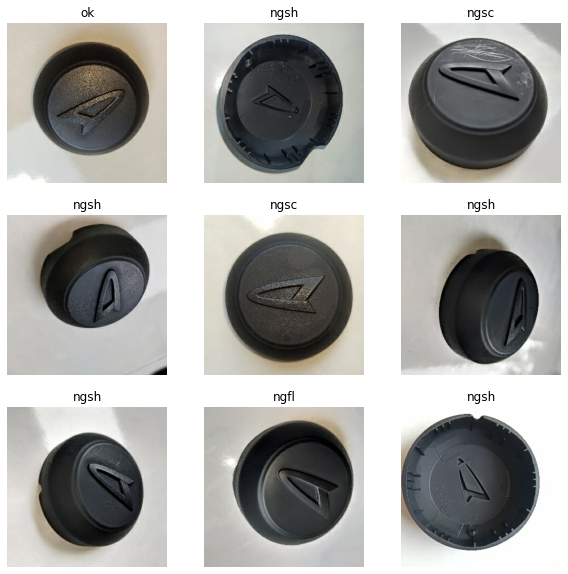

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataset.class_names[labels[i]])
    plt.axis("off")

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomTranslation(0.08, 0.08, fill_mode='nearest'),
  tf.keras.layers.RandomRotation(0.5),
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(4)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 10s 989ms/step - loss: 1.4633 - accuracy: 0.2523


In [9]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.46
initial accuracy: 0.25


In [10]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
28/28 [==============================] - 13s 360ms/step - loss: 1.4012 - accuracy: 0.3272 - val_loss: 1.3035 - val_accuracy: 0.4019
Epoch 2/10
28/28 [==============================] - 8s 289ms/step - loss: 1.2937 - accuracy: 0.4090 - val_loss: 1.2419 - val_accuracy: 0.4766
Epoch 3/10
28/28 [==============================] - 8s 290ms/step - loss: 1.2440 - accuracy: 0.4528 - val_loss: 1.1885 - val_accuracy: 0.4860
Epoch 4/10
28/28 [==============================] - 8s 290ms/step - loss: 1.1726 - accuracy: 0.4954 - val_loss: 1.1465 - val_accuracy: 0.5140
Epoch 5/10
28/28 [==============================] - 8s 289ms/step - loss: 1.1428 - accuracy: 0.5081 - val_loss: 1.1113 - val_accuracy: 0.5421
Epoch 6/10
28/28 [==============================] - 8s 289ms/step - loss: 1.1070 - accuracy: 0.5173 - val_loss: 1.0815 - val_accuracy: 0.5981
Epoch 7/10
28/28 [==============================] - 8s 288ms/step - loss: 1.0458 - accuracy: 0.5553 - val_loss: 1.0543 - val_accuracy: 0.5888
Epoch

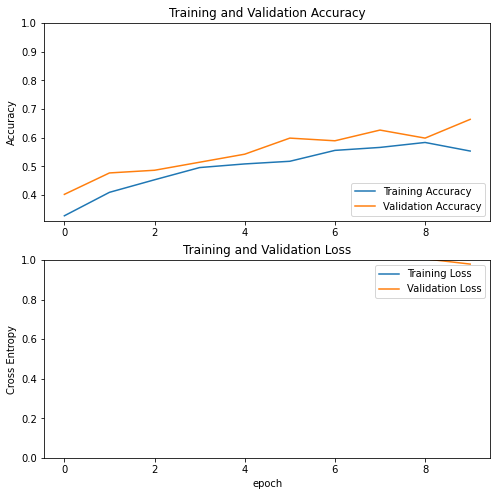

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
base_model.trainable = True

In [13]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


In [14]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [16]:
len(model.trainable_variables)

98

In [17]:
fine_tune_epochs = 12
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/22
28/28 [==============================] - 25s 621ms/step - loss: 0.7563 - accuracy: 0.6935 - val_loss: 0.7044 - val_accuracy: 0.7009
Epoch 11/22
28/28 [==============================] - 16s 555ms/step - loss: 0.4750 - accuracy: 0.8353 - val_loss: 0.5033 - val_accuracy: 0.8318
Epoch 12/22
28/28 [==============================] - 16s 554ms/step - loss: 0.3433 - accuracy: 0.8767 - val_loss: 0.5460 - val_accuracy: 0.7477
Epoch 13/22
28/28 [==============================] - 16s 553ms/step - loss: 0.2228 - accuracy: 0.9343 - val_loss: 0.3363 - val_accuracy: 0.8692
Epoch 14/22
28/28 [==============================] - 16s 552ms/step - loss: 0.1733 - accuracy: 0.9516 - val_loss: 0.1827 - val_accuracy: 0.9346
Epoch 15/22
28/28 [==============================] - 16s 553ms/step - loss: 0.1395 - accuracy: 0.9539 - val_loss: 0.2907 - val_accuracy: 0.8972
Epoch 16/22
28/28 [==============================] - 16s 554ms/step - loss: 0.0994 - accuracy: 0.9666 - val_loss: 0.1235 - val_accuracy:

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

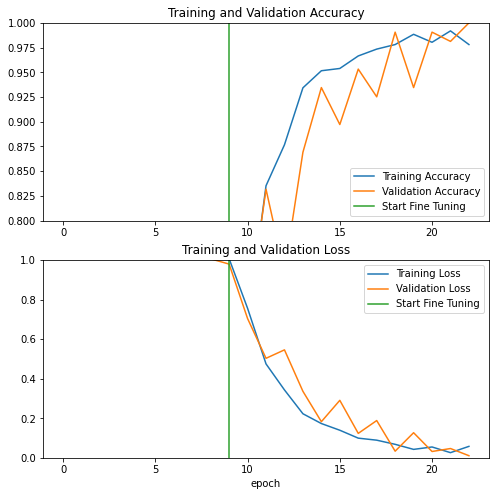

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 3s 914ms/step - loss: 0.0093 - accuracy: 1.0000
Test accuracy : 1.0


In [22]:
model.save('dai-v4.h5')